In [1]:
%matplotlib inline
import os
import re
import glob
from collections import Counter
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import linear_model

import file_handling as fh

sbn.set(font_scale=1.5)


/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
data_dir = '/Users/dcard/Projects/CMU/ARK/LN_tools/parsed/StanfordMSA/'
spreadsheet_file = '/Users/dcard/Dropbox/CMU/ARK/terrorism/databases/MSA/Data/Stanford_MSA_Database.csv'
race_file = '/Users/dcard/Projects/CMU/ARK/terrorism/Stanford_MSA/race.csv'
output_dir = './data/msa/'

msa_df = pd.read_csv(spreadsheet_file, header=0)
race_df = pd.read_csv(race_file, header=0, index_col=0)
race_df.head()

,CaseID,Title,EKG Race,simple_race,White
330,340,Fort Warne drive by,Unknown,Unknown,-1
331,341,Cape Coral Shooting Spree,White,White,1
332,342,"Webster, MN party shooting",Unknown,Unknown,-1
333,343,Orlando Nightclub Massacre,MiddleEastern,Middle Eastern,0
334,344,Nightclub Disput,Black,Black,0


{'Custody', 'Custody/Escaped', 'Escaped', 'Killed', 'Arrested', 'Deceased'}
{nan, 'FALSE', 'Custody', 'Custody/Escaped', 'Custody / Escaped', 'Escaped', 'Arrested', 'Deceased'}
{'Unknown', 'Restaurant/cafe', 'Public transportation', 'Secondary school', 'Public Transportation', 'Residential home/Neighborhood,\nRetail/ Wholesale/Services facility', 'Military facility', 'Residential home', 'Place of worship', 'Retail/Wholesale/Services facility\n/Residential home/Neighborhood', 'Retail/Wholesale/Services facility', 'Restaurant/Cafe?', 'Residential home/Neighborhood \nand Street/Highway', 'Secondary School', 'Park/Wilderness', 'Restaurant/Cafe', 'Retail/ Wholesale/Services facility\nand Primary school', 'Company/Factory/Office', 'Primary school', 'College/University/Adult education', 'Park/Wildness', 'Street/Highway', 'Entertainment venue', 'Residential Home/Neighborhood', 'Retail/ Wholesale/Services facility', 'Residential home/Neighborhood', 'Restaurant/Cafeé', 'Entertainment Venue', 'Go

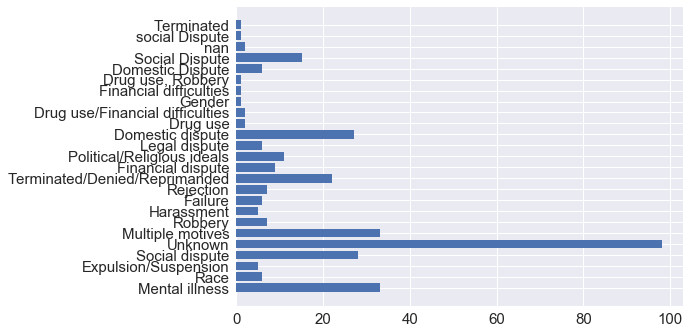

In [3]:
print(set(msa_df['Fate of Shooter at the scene'].values))
print(set(msa_df['Fate of Shooter'].values))
print(set(msa_df['Place Type'].values), len(set(msa_df['Place Type'].values)))
print(set(msa_df['Shooter Sex'].values))
print(set(msa_df['Shooter Race'].values))
print(set(msa_df["Shooter's Cause of Death"].values))
print(set(msa_df["History of Mental Illness - General"].values))
print(set(msa_df["Military Experience"].values))
counts = Counter()
fig, ax = plt.subplots()
counts.update(msa_df["Possible Motive - General"].values)
keys = list(counts.keys())
vals = [counts[k] for k in keys]
ax.barh(np.arange(len(vals)), vals)
ax.set_yticks(np.arange(len(vals)))
ax.set_yticklabels(keys)
plt.show();

In [4]:
msa_descriptions = []
df = pd.DataFrame(columns=['caseid', 'title', 'date', 'year', 'civilian_fatalities', 'enforcement_fatalities', 'n_fatalities', 'n_victims', 'n_articles', 'lat', 'long', 'race', 'name'])
articles = []
articles_by_incident = {}
to_save = []

df_out = pd.DataFrame(columns=['df_index', 'caseid', 'title', 'city', 'n_fatalities', 'n_victims', 'n_shooters', 'name', 'race', 'description', 'article', 'article_name', 'simple_race', 'white'])
df_out_count = 0


for index in msa_df.index:
    row = msa_df.loc[index]
    caseid = int(row['CaseID'])
    title = row['Title']
    city = row['City']
    state = row['State']
    lat = row['Latitude']
    long = row['Longitude']
    civilian_fatalities = row['Number of Civilian Fatalities']
    civilian_injuries = row['Number of Civilian Injured']
    enforcement_fatalities = row['Number of Enforcement Fatalities']
    enforcement_injuries = row['Number of Enforcement Injured']
    n_fatalities = int(row['Total Number of Fatalities'])
    n_victims = int(row['Total Number of Victims'])
    description = row['Description']
    date = pd.to_datetime(row['Date'])
    year = date.year
    name = row['Shooter Name']
    n_shooters = row['Number of shooters']
    shooter_age = row['Average Shooter Age']
    sex = row['Shooter Sex']
    race = row['Shooter Race']
    n_shotguns = row['Number of Shotguns']
    n_rifles = row['Number of Rifles']
    n_handguns = row['Number of Handguns']
    n_guns = row['Total Number of Guns']
    n_automatic = row['Number of Automatic Guns']
    n_semi = row['Number of Semi-Automatic Guns']
    fate_at_scene = row['Fate of Shooter at the scene']
    fate_of_shooter = row['Fate of Shooter']
    cause_of_death = row["Shooter's Cause of Death"]
    school_related = row['School Related']
    place_type = row['Place Type']
    relationship_to_place = row['Relationship to Incident Location']
    target_details = row['Targeted Victim/s - Detailed']
    target_general = row['Targeted Victim/s - General']
    motive_details = row['Possible Motive - Detailed']
    motive_general = row['Possible Motive - General']
    mental_details = row['History of Mental Illness - Detailed']
    mental_general = row['History of Mental Illness - General']
    military = row['Military Experience']
    event_type = row['Class']   # MS = mass shooting, SPK = spree killing, SEK = serial, GD = gang/drug, FMS = family murder/suicide
    depreciation = row['Depreciation']  # 0 = does not fit criteria; 2 = borderline

    simple_race = race_df.loc[index, 'simple_race']
    white = race_df.loc[index, 'White']
    
    msa_descriptions.append({'id': caseid, 'text': description})
 
    input_dir = os.path.join(data_dir, str(caseid) + '_' + '_'.join(name.split()))
    if os.path.exists(input_dir):        
        n_articles = len(glob.glob(os.path.join(input_dir, 'partition', '1', '1', '*.txt')))
        df.loc[index] = [caseid, title, date, year, civilian_fatalities, enforcement_fatalities, n_fatalities, n_victims, n_articles, lat, long, race, name]
        metadata = fh.read_json(os.path.join(input_dir, 'metadata', 'metadata.json'))
        for article_name in metadata:
            fulldate = metadata[article_name]['fulldate']
            source = metadata[article_name]['source']
            filename = os.path.join(input_dir, 'partition', '1', '1', article_name + '_short.txt')
            if os.path.exists(filename):
                with open(filename, 'r') as f:
                    text = f.read()
                paragraphs = text.split('\n\n')[2:]
                # add a period after headline to help parser
                paragraphs[0] += '.'
                text = '\n'.join(paragraphs)
                article_dict = {'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'eventdate': date, 'race': race}
                articles.append(article_dict)
                to_save.append({'text': text, 'id': index, 'caseid': caseid, 'source': source, 'fulldate': fulldate, 'name': name})
                if index not in articles_by_incident:
                    articles_by_incident[index] = []
                articles_by_incident[index].append(article_dict)
                df_out.loc[df_out_count] = [index, caseid, title, city, n_fatalities, n_victims, n_shooters, name, race, description, ' '.join(paragraphs), os.path.split(filename)[-1], simple_race, white]
                df_out_count += 1

df['n_articles'] = pd.to_numeric(df['n_articles'])
df['n_victims'] = pd.to_numeric(df['n_victims'])
df['n_fatalities'] = pd.to_numeric(df['n_fatalities'])

print(df.isnull().values.any())

print(len(articles))
fh.write_jsonlist(to_save, os.path.join(output_dir, 'articles.jsonlist'))
df_out.to_csv(os.path.join(output_dir, 'articles.csv'))
df.head()

False
5857


,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name
31,32,GMAC Loan Office,1990-06-17,1990,11,0,12,17,23,30.332161,-81.675770,Black American or African American,James Edward Pough
32,33,University of Iowa,1991-11-01,1991,5,0,6,6,8,41.655894,-91.531180,Asian American,Gang Lu
33,34,Ridgewood Post Office,1991-10-10,1991,3,0,3,3,5,40.982133,-74.112647,Black American or African American,Joseph M. Harris
34,35,"Luby's Cafeteria in Killeen, Texas",1991-10-16,1991,23,0,24,43,25,31.079255,-97.733923,White American or European American,George Hennard
35,36,Royal Oak Post Office,1991-11-14,1991,4,0,5,9,8,42.508402,-83.153874,White American or European American,Thomas McIlvane


In [29]:
sources = set()
for article in articles:
    source = article['source']
    sources.add(source)
print(sources)

{'san jose mercury news', 'usa today', 'st. louis post-dispatch', 'daily news', 'tampa bay times', 'washington post', 'philadelphia inquirer', 'saint paul pioneer press', 'palm beach post', 'atlanta journal and constitution', 'new york times', 'st. petersburg times'}


In [6]:
name_tokens = set()
names = {}
for i in df.index:
    name = df.loc[i, 'name']
    tokens = name.split()
    tokens = [token for token in tokens if token[0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']
    tokens = [token for token in tokens if '.' not in token]
    tokens = [re.sub(r',', '', token) for token in tokens]
    tokens = [re.sub(r'\?', '', token) for token in tokens]
    tokens = [token for token in tokens if token not in ['Unknown', 'Unkown', 'One', 'Two', 'Jr', 'II', 'III', 'IV', 'The']]
    tokens = [token for token in tokens if len(token) > 1]
    names[i] = tokens
    name_tokens.update(tokens)
name_tokens = list(name_tokens)
name_tokens.sort()
print(len(names))

300


In [7]:
# look at matching names
for i in df_out.index:
    df_index = df_out.loc[i, 'df_index']
    article_text = df_out.loc[i, 'article']
    shooter_names = names[df_index]
    df_out.loc[i, 'shooter_names'] = ' '.join(shooter_names)
    age = msa_df.loc[df_index, 'Average Shooter Age']
    city = msa_df.loc[df_index, 'City']
    prop = 0.0
    for name in shooter_names:
        if name in article_text:
            prop += 1.0 / len(shooter_names)            
    df_out.loc[i, 'prop_names_found'] = prop
    age_string = age + "-year-old"
    if age_string in article_text:
        age_found = True
        df_out.loc[i, 'age_found'] = 1
    else:
        age_found = False
        df_out.loc[i, 'age_found'] = 0

    if city in article_text:
        city_found = True
        df_out.loc[i, 'city_found'] = 1
    else:
        city_found = False
        df_out.loc[i, 'city_found'] = 0
    
    if prop > 0 or age_found or city_found:
        df_out.loc[i, 'matching'] = 1
    else:
        df_out.loc[i, 'matching'] = 0
        
    # zero out Cape Coral!
    
    
    df_out.loc[i, 'age'] = age

n_items, n_columns = df_out.shape
order = np.arange(n_items)
np.random.shuffle(order)
df_out['order'] = order

df_out.to_csv(os.path.join(output_dir, 'articles.csv'))

In [8]:
df['n_incidents'] = 1
grouped = df.groupby('year')
summed = grouped.aggregate(np.sum)
summed.head()


,n_fatalities,n_victims,n_articles,lat,long,n_incidents
year,,,,,,
1990,12,17,23,30.332161,-81.675770,1
1991,47,70,52,189.797143,-458.622110,5
1992,11,30,39,158.838696,-373.664933,4
1993,29,75,128,357.377798,-883.767755,9
1994,12,42,61,170.501175,-354.924583,4


In [41]:
temp = [a for a in articles if a['id'] == 97]
asia_count = 0
korea_count = 0
for a in temp:
    if 'asia' in a['text'].lower():
        asia_count += 1
    if 'korea' in a['text'].lower():
        korea_count += 1
print(len(temp))
print(asia_count)
print(korea_count)

134
18
17


In [9]:
df.tail(n=3)

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
332,342,"Webster, MN party shooting",2016-06-11,2016,0,0,0,4,4,44.529686,-93.352723,Unknown,Unknown,1
333,343,Orlando Nightclub Massacre,2016-06-12,2016,49,0,50,102,400,28.538335,-81.379236,Some other race,Omar Marteen,1
334,344,Nightclub Disput,2016-06-26,2016,0,0,0,3,3,34.948174,-82.127331,Black American or African American,Jody Ray Thompson,1


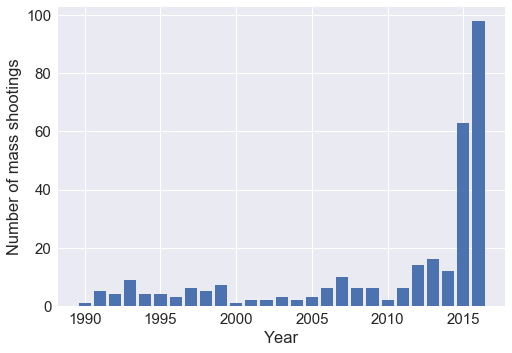

In [40]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_incidents)
ax.set_xlabel('Year')
#ax.set_title('Number of incidents per year');
ax.set_ylabel('Number of mass shootings')
plt.savefig('plots/incidents_per_year.pdf', bbox_inches='tight')


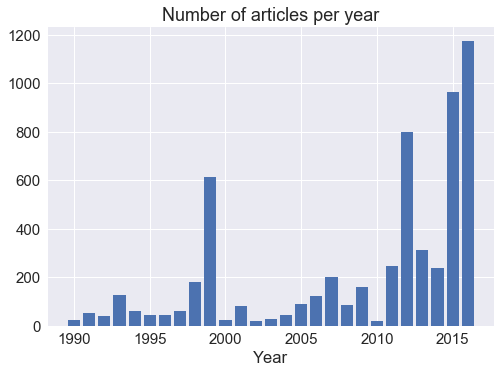

In [8]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles)
ax.set_xlabel('Year')
ax.set_title('Number of articles per year');

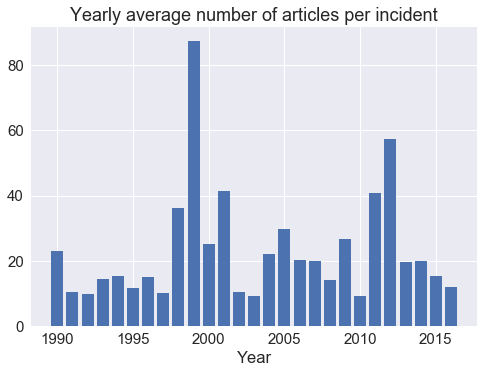

In [9]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_articles / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of articles per incident');


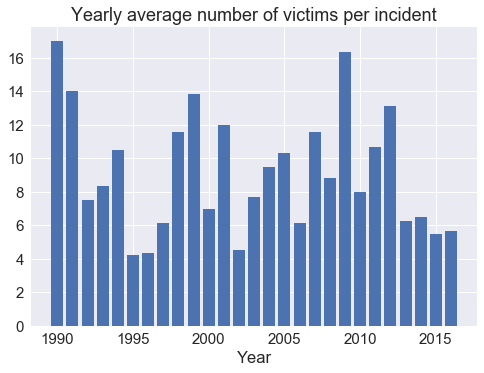

In [10]:
fig, ax = plt.subplots(1, 1)
ax.bar(summed.index, summed.n_victims / summed.n_incidents)
ax.set_xlabel('Year')
ax.set_title('Yearly average number of victims per incident');


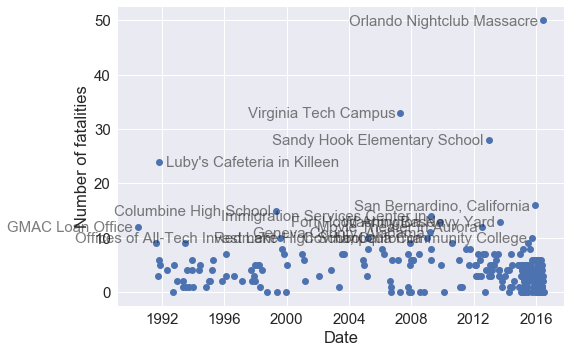

In [54]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_fatalities)
subset = df[df.n_fatalities >= 10]
for i in subset.index:
    row = subset.loc[i]
    if row.title.startswith('Luby'):
        ax.annotate(' '.join(row.title.split()[:4])[:-1], xy=(row.date, row.n_fatalities), size=15, xytext=(7, -5), textcoords='offset points', alpha=0.6, horizontalalignment='left')
    else:
        ax.annotate(' '.join(row.title.split()[:4]), xy=(row.date, row.n_fatalities), size=15, xytext=(-5, -5), textcoords='offset points', alpha=0.6, horizontalalignment='right')
ax.set_xlabel('Date')
ax.set_ylabel('Number of fatalities');
plt.savefig('plots/fatalities.pdf')

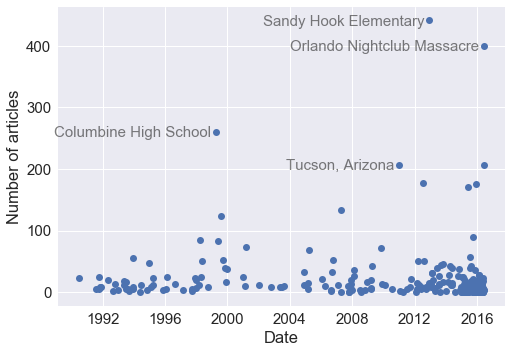

In [49]:
fig, ax = plt.subplots(1, 1)
ax.plot_date(df.date, df.n_articles)
subset = df[df.n_articles > 206]
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.title.split()[:3]), xy=(row.date, row.n_articles), size=15, xytext=(-5, -5), textcoords='offset points', alpha=0.6, horizontalalignment='right')
ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
#ax.set_title('Number of articles per incident')
plt.savefig('plots/articles_per_event.pdf')

In [13]:
df.sort_values('n_articles', ascending=False).head(n=10)


,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
137,138,Sandy Hook Elementary School,2012-12-14,2012,27,0,28,29,441,41.411908,-73.311963,White American or European American,Adam Lanza,1
333,343,Orlando Nightclub Massacre,2016-06-12,2016,49,0,50,102,400,28.538335,-81.379236,Some other race,Omar Marteen,1
70,71,Columbine High School,1999-04-20,1999,13,0,15,37,260,39.593583,-105.015211,White American or European American,Eric Harris and Dylan Klebold,1
119,120,"Tucson, Arizona",2011-01-08,2011,6,0,6,19,207,32.153589,-110.967765,White American or European American,Jared Lee Loughner,1
331,341,Cape Coral Shooting Spree,2016-06-07,2016,2,0,3,5,206,26.562854,-81.949533,White American or European American,Christopher Michael Moran,1
131,132,Movie Theater in Aurora,2012-07-20,2012,12,0,12,70,177,39.729419,-104.982521,White American or European American,James Eagan Holmes,1
235,245,"San Bernardino, California",2015-12-02,2015,14,0,16,35,175,34.139734,-117.294244,Asian American,Syed Rizwyan Farook\nTashfeen Malik,1
207,215,Mother Emanuel AME Church,2015-06-17,2015,9,0,9,9,171,32.812973,-79.966940,White American or European American,Dylann Storm Roof,1
97,98,Virginia Tech Campus,2007-04-16,2007,32,0,33,49,134,37.229955,-80.427687,Asian American,Seung-Hui Cho,1
72,73,Offices of All-Tech Investment Group and Momen...,1999-07-29,1999,9,0,10,21,123,33.762997,-84.423133,White American or European American,Mark Orrin Barton,1


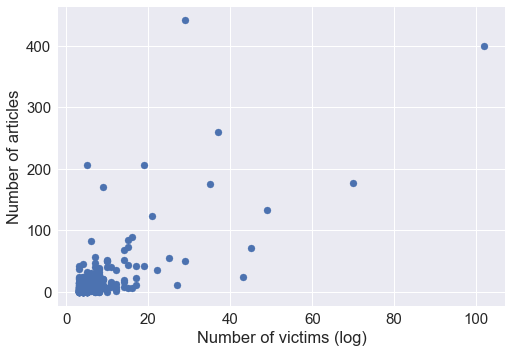

In [14]:
fig, ax = plt.subplots(1, 1)
ax.scatter(np.array(df.n_victims.values, dtype='float'), np.array(df.n_articles.values, dtype='float'))
ax.set_xlabel('Number of victims (log)')
ax.set_ylabel('Number of articles');


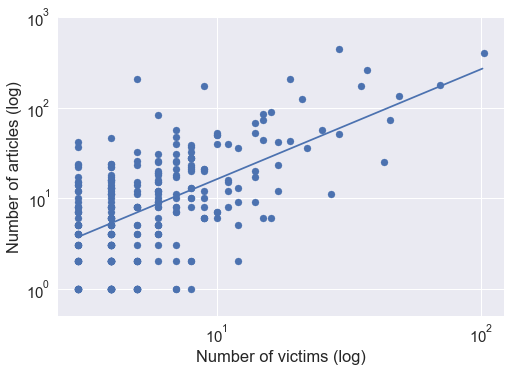

In [15]:
fig, ax = plt.subplots(1, 1)
df_sub = df[df.n_articles > 0]
x = np.array(df_sub.n_victims.values, dtype='float')
y = np.array(df_sub.n_articles.values, dtype='float')
ax.scatter(x, y)
ax.set_xlabel('Number of victims (log)')
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_ylabel('Number of articles (log)');
ax.set_ylim(0.5, 1000)

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(np.log(x).reshape(-1, 1), np.log(y))
x_pred = np.log(np.arange(np.min(x), np.max(x)).reshape(-1, 1))
pred = model.predict(x_pred)
ax.plot(np.exp(x_pred), np.exp(pred))

In [16]:
sources = set([article['source'] for article in articles])
print(sources)

{'san jose mercury news', 'palm beach post', 'tampa bay times', 'atlanta journal and constitution', 'daily news', 'washington post', 'new york times', 'st. petersburg times', 'saint paul pioneer press', 'usa today', 'st. louis post-dispatch', 'philadelphia inquirer'}


In [17]:
event_dates = dict()
articles_per_source = defaultdict(int)
terrorism_mentions_per_source = defaultdict(int)
articles_per_year = defaultdict(int)
terrorism_mentions_per_year = defaultdict(int)
articles_per_event = defaultdict(int)
terrorism_mentions_per_event = defaultdict(int)
articles_per_race = defaultdict(int)
terrorism_mentions_per_race = defaultdict(int)
for article in articles:
    caseid = article['caseid']
    #if caseid != 245 and caseid != 341 and caseid != 343:
    if True:
        source = article['source']
        event_date = article['eventdate']
        race = article['race']
        year = int(str(article['fulldate'])[:4])
        text = article['text'].lower()    
        event_dates[caseid] = event_date
        articles_per_source[source] += 1
        articles_per_event[caseid] += 1
        articles_per_year[year] += 1
        articles_per_race[race] += 1
        if 'terrorism' in text or 'terrorist' in text:
            terrorism_mentions_per_source[source] += 1
            terrorism_mentions_per_event[caseid] += 1
            terrorism_mentions_per_year[year] += 1
            terrorism_mentions_per_race[race] += 1
event_titles = dict(zip(df.caseid.values, df.title.values))


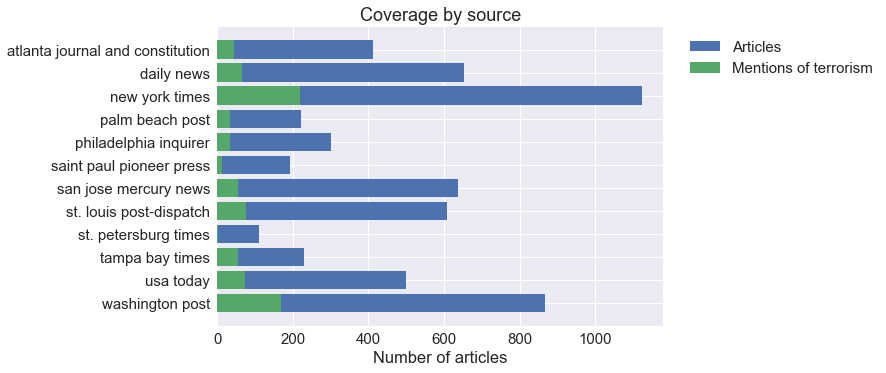

In [18]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_source[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by source')

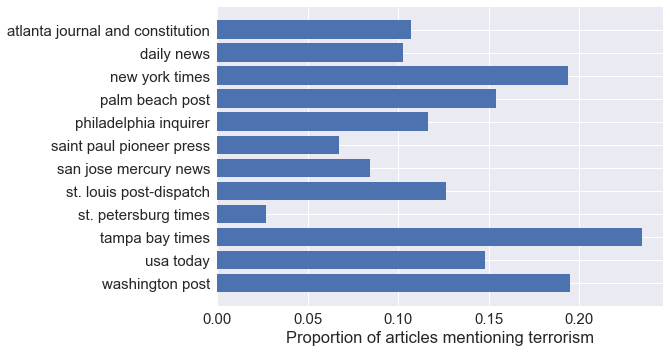

In [19]:
keys = list(articles_per_source.keys())
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_source[k]/articles_per_source[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.set_xlabel('Proportion of articles mentioning terrorism')

245 2015-12-02 00:00:00 San Bernardino, California
341 2016-06-07 00:00:00 Cape Coral Shooting Spree
343 2016-06-12 00:00:00 Orlando Nightclub Massacre


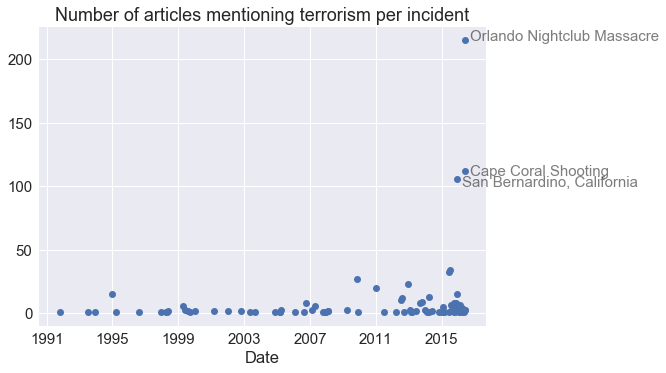

In [20]:
fig, ax = plt.subplots()
#ax.plot_date(list(articles_per_event.keys()), list(articles_per_event.values()))
keys = list(terrorism_mentions_per_event.keys())
dates = [event_dates[caseid] for caseid in keys]
mentions = [terrorism_mentions_per_event[caseid] for caseid in keys]
ax.plot_date(dates, mentions)
count = 0
for caseid in keys:
    if terrorism_mentions_per_event[caseid] > 100:
        count += 1 
        print(caseid, event_dates[caseid], event_titles[caseid])
        ax.annotate(' '.join(event_titles[caseid].split()[:3]), xy=(event_dates[caseid], terrorism_mentions_per_event[caseid]), size=15, xytext=(5, -12 +4*count), textcoords='offset points', alpha=0.6)
ax.set_xlabel('Date')
ax.set_title('Number of articles mentioning terrorism per incident')

116
158
168
222
240
241
244
245
263
280
341
343


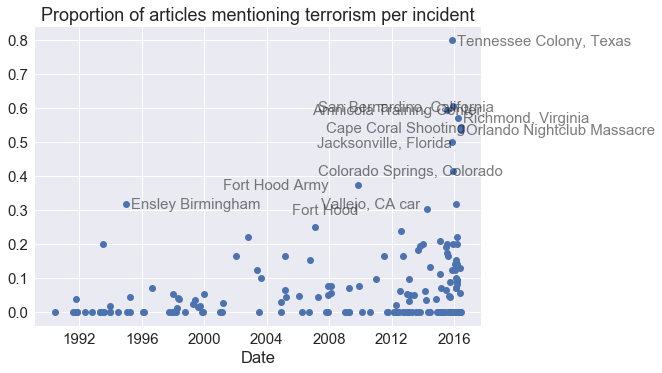

In [21]:
keys = [key for key in articles_per_event.keys() if articles_per_event[key] > 4]
dates = [event_dates[caseid] for caseid in keys]
proportion = [terrorism_mentions_per_event[caseid] / articles_per_event[caseid] for caseid in keys]
fig, ax = plt.subplots()
count = 0
ax.plot_date(dates, proportion)
for caseid in keys:
    year = event_dates[caseid].year
    proportion = terrorism_mentions_per_event[caseid] / articles_per_event[caseid]
    if proportion > 0.3:
        print(caseid)
        count += 1        
        ax.annotate(' '.join(event_titles[caseid].split()[:3]), xy=(event_dates[caseid], proportion), size=15, xytext=(5 -140*((count%3)>0), -5), textcoords='offset points', alpha=0.6)

ax.set_xlabel('Date')
ax.set_title('Proportion of articles mentioning terrorism per incident')

In [22]:
df[df.caseid == 44]

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
43,44,Weber State University,1993-07-08,1993,0,0,1,3,5,41.228137,-111.967532,Asian American,Mark Duong,1


In [23]:
df[df.caseid == 168]

,caseid,title,date,year,civilian_fatalities,enforcement_fatalities,n_fatalities,n_victims,n_articles,lat,long,race,name,n_incidents
168,168,Massachusetts Abortion Clinic,1994-12-30,1994,2,0,2,7,47,42.324274,-71.140800,White American or European American,John Salvi III,1
169,168,Ensley Birmingham,2012-01-29,2012,5,0,5,5,0,33.528287,-86.795504,Black American or African American,"Rashad Stoves, Artavius Underwood, Reginald Mims",1


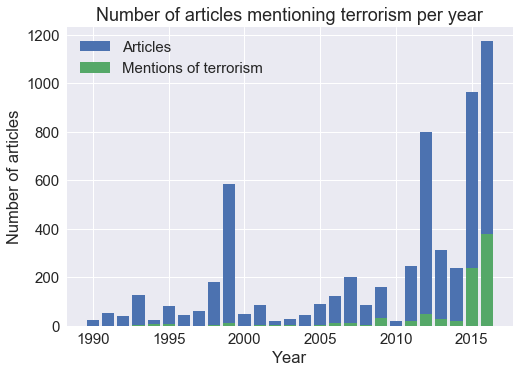

In [24]:
keys = list(articles_per_year.keys())
keys.sort()
fig, ax = plt.subplots()
ax.bar(keys, [articles_per_year[k] for k in keys], label='Articles')
ax.bar(keys, [terrorism_mentions_per_year[k] for k in keys], label='Mentions of terrorism')
ax.set_xlabel('Year')
ax.set_ylabel('Number of articles')
ax.legend()
ax.set_title('Number of articles mentioning terrorism per year')

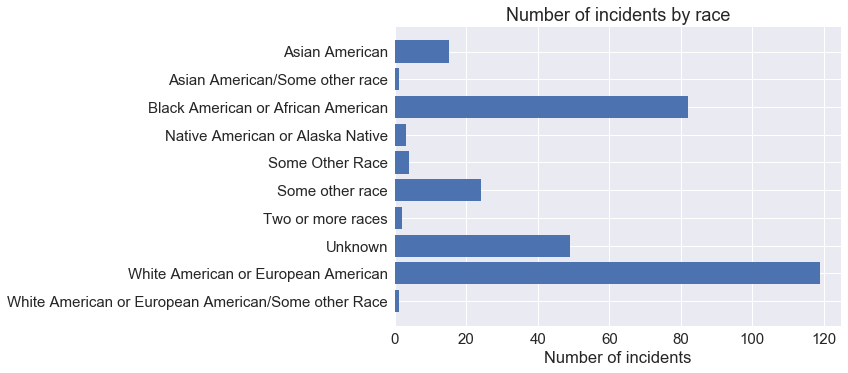

In [25]:
grouped = df.groupby('race')
summed_by_race = grouped.aggregate(np.sum)
summed_by_race.sort_index()
races = list(summed_by_race.index)
fig, ax = plt.subplots()
yticks = list(range(len(races)))
yticks.reverse()
ax.barh(yticks, width=summed_by_race.n_incidents)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of incidents')
ax.set_title('Number of incidents by race');


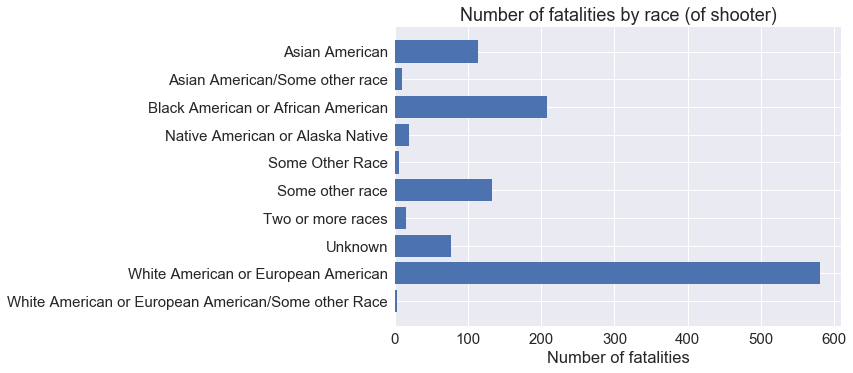

In [26]:
fig, ax = plt.subplots()
ax.barh(yticks, width=summed_by_race.n_fatalities)
ax.set_yticks(yticks)
ax.set_yticklabels(races)
ax.set_xlabel('Number of fatalities')
ax.set_title('Number of fatalities by race (of shooter)');

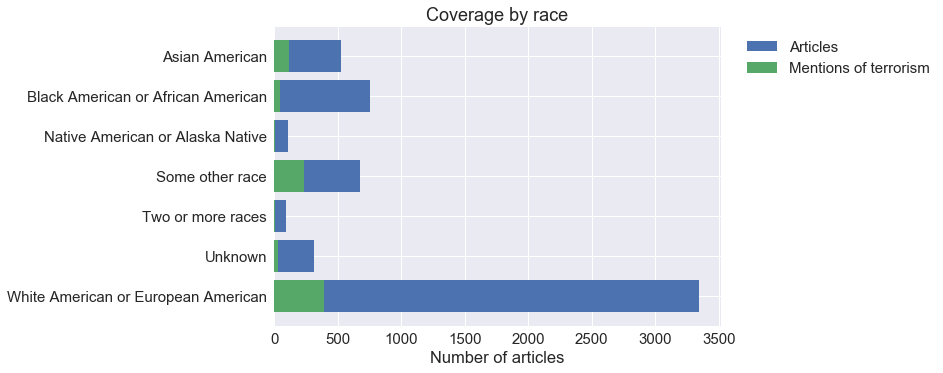

In [27]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [articles_per_race[k] for k in keys], label='Articles')
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] for k in keys], label='Mentions of terrorism')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Number of articles')
ax.set_title('Coverage by race');

/Users/dcard/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


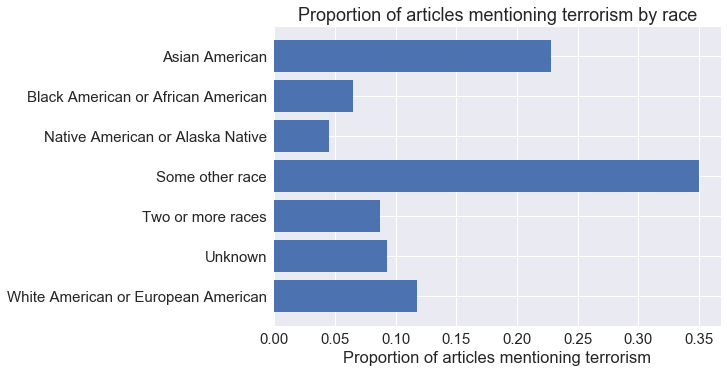

In [28]:
keys = list(articles_per_race.keys())
keys = [k for k in keys if articles_per_race[k] > 50]
keys.sort(reverse=True)
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), [terrorism_mentions_per_race[k] / articles_per_race[k] for k in keys])
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys);
ax.legend(bbox_to_anchor=(1.5, 1))
ax.set_xlabel('Proportion of articles mentioning terrorism')
ax.set_title('Proportion of articles mentioning terrorism by race');

In [29]:
# Can I make a map in matplotlib? Yes!
from mpl_toolkits.basemap import Basemap
import math

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

scale = 1.0
for i in df.index:
    row = df.loc[i]  
    x, y = map(row.long, row.lat)
    map.plot(x, y, marker='o', color='Blue', markersize=(row['n_fatalities'])*scale, alpha=0.4)
    #map.plot(x, y, marker='o', color='Red', markersize=(row['n_articles'])*scale/10., alpha=0.7)
plt.show();

OSError: cannot locate st99_d00.shp

In [38]:
counts = []
for article in articles:
    source = article['source']
    event_date = article['eventdate']
    race = article['race']
    year = int(str(article['fulldate'])[:4])
    text = article['text'].lower()    
    terrorism = 0
    if 'terrorism' in text or 'terrorist' in text:
        terrorism = 1
    islam = 0
    if 'islam' in text or 'muslim' in text:
        islam = 1
    mental = 0
    if 'mental' in text:
        mental = 1
    counts.append([terrorism, islam, mental])
n = len(counts)
counts = np.vstack(counts)
sums = counts.sum(axis=0)
df_counts = pd.DataFrame(counts, columns=['terrorism', 'islam', 'mental'])
print(df_counts.mean())
print(df_counts[df_counts.terrorism == 1].mean())
print(df_counts[df_counts.islam == 1].mean())
print(df_counts[df_counts.mental == 1].mean())



terrorism    0.143760
islam        0.107393
mental       0.171248
dtype: float64
terrorism    1.000000
islam        0.511876
mental       0.260095
dtype: float64
terrorism    0.685215
islam        1.000000
mental       0.248013
dtype: float64
terrorism    0.218345
islam        0.155533
mental       1.000000
dtype: float64


In [39]:
n_sources = len(set(sources))
years = range(df.year.min(), df.year.max()+1)
articles_per_year_by_source = {source: {year: 0 for year in years} for source in sources}
for article in articles:
    source = article['source']
    year = int(str(article['fulldate'])[:4])
    articles_per_year_by_source[source][year] += 1


NameError: name 'sources' is not defined

In [ ]:
fig, axes = plt.subplots(n_sources, 1, figsize=(8, 10), sharex=True, sharey=True)
sources = list(sources)
sources.sort()
for i, source in enumerate(sources):
    years = list(articles_per_year_by_source[source].keys())
    counts = [articles_per_year_by_source[source][year] for year in years]
    axes[i].bar(years, counts)
    axes[i].text(2018, 100, source)
    axes[i].set_yticks([100, 200])
    


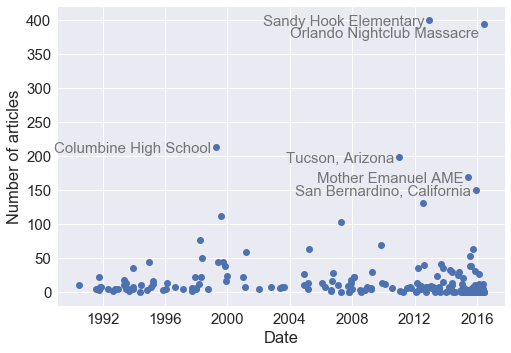

In [41]:
input_dir = os.path.join('data', 'msa')
df_parsed = pd.read_csv(os.path.join(input_dir, 'terrorism_counts.csv'), header=0, index_col=0)
df_parsed = df_parsed[df_parsed.year >= 1990]

fig, ax = plt.subplots(1, 1)
ax.plot_date(df_parsed.date, df_parsed.n_valid_articles)
subset = df_parsed[df_parsed.n_valid_articles > 135]
for i in subset.index:
    offset = 0
    row = subset.loc[i]
    if row.Title == 'Orlando Nightclub Massacre':
        offset = -8
    ax.annotate(' '.join(row.Title.split()[:3]), xy=(row.date, row.n_valid_articles), size=15, xytext=(-5, -5+offset), textcoords='offset points', alpha=0.6, horizontalalignment='right')

ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
#ax.set_title('Number of articles per incident')
plt.savefig('plots/articles_per_event.pdf')


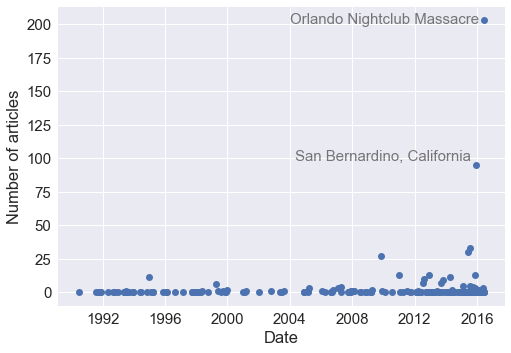

In [42]:
fig, ax = plt.subplots(1, 1)

#for i in df_parsed.index:
#    df_parsed.loc[i, 'terrorism_prop']

ax.plot_date(df_parsed.date, df_parsed.n_terrorism_mentions)
subset = df_parsed[df_parsed.n_terrorism_mentions > 50]
count = 0
for i in subset.index:
    row = subset.loc[i]
    ax.annotate(' '.join(row.Title.split()[:3]), xy=(row.date, row.n_terrorism_mentions), size=15, xytext=(-5, -5-count*8+10), textcoords='offset points', alpha=0.6, horizontalalignment='right')
    count += 1
ax.set_xlabel('Date')
ax.set_ylabel('Number of articles');
#ax.set_title('Number of articles per incident')


(303, 63)
(12, 63)


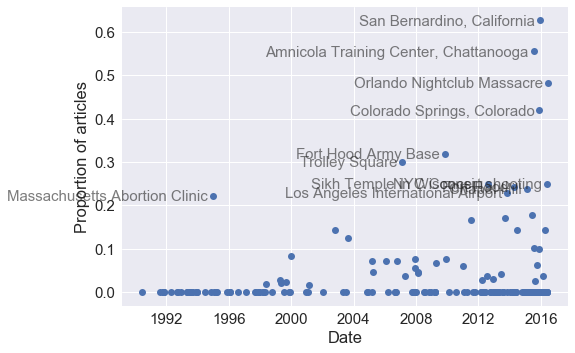

In [52]:
fig, ax = plt.subplots(1, 1)

df_parsed['terrorism_prop'] = 0
for i in df_parsed.index:
    if df_parsed.loc[i, 'n_valid_articles'] > 4:
        #df_parsed.loc[i, 'terrorism_prop'] = df_parsed.loc[i, 'n_terrorism_mentions'] / df_parsed.loc[i, 'n_valid_articles']
        df_parsed.loc[i, 'terrorism_prop'] = df_parsed.loc[i, 'n_unnegated_terrorism_mentions'] / df_parsed.loc[i, 'n_valid_articles']

print(df_parsed.shape)
covered = df_parsed[df_parsed.n_valid_articles > 0]

ax.plot_date(covered.date, covered.terrorism_prop)

subset = covered[covered.terrorism_prop > 0.2]
print(subset.shape)
for i in subset.index:
    offset = 0
    row = covered.loc[i]
    #if row.Title == 'Trolley Square':
    #    offset = -6
    ax.annotate(' '.join(row.Title.split()[:4]), xy=(row.date, row.terrorism_prop), size=15, xytext=(-5, -5+offset), textcoords='offset points', alpha=0.6, horizontalalignment='right')
    count += 1
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of articles');
#ax.set_title('Number of articles per incident')
plt.savefig('plots/terrorism_mentions.pdf')


In [38]:
print(df_out.shape)
df_out.tail(n=3)

(5857, 19)


,df_index,caseid,title,city,n_fatalities,n_victims,n_shooters,name,race,description,article,article_name,shooter_names,prop_names_found,age_found,city_found,matching,age,order
5854,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...","After S.C. killings, families sue over backgro...",344_Jody_Ray_Thompson-7_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,5575
5855,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",The Prosecutors Who Aim to Kill; Editorial. On...,344_Jody_Ray_Thompson-5_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,3979
5856,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",Survivors of Charleston Church Attack Sue F.B....,344_Jody_Ray_Thompson-2_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,4749


In [33]:
age = msa_df.loc[333, 'Average Shooter Age']
print(age)
age_string = age + "-year-old"
text = df_out.loc[5471, 'article']
print(age_string in text)
print(age + "-year-old" in text)


29
True
True


In [149]:
# Kalamazoo duplicate
for i in msa_df.index:
    if msa_df.loc[i, 'CaseID'] == 250 or  msa_df.loc[i, 'CaseID'] == 282:
        print(i, df.loc[i])
    

240 caseid                                                    250
title                                     Kalamazoo, Michigan
date                                      2016-02-20 00:00:00
year                                                     2016
civilian_fatalities                                         6
enforcement_fatalities                                      0
n_fatalities                                                6
n_victims                                                   8
n_articles                                                 28
lat                                                   42.2354
long                                                  -85.676
race                      White American or European American
name                                       Jason Brian Dalton
n_incidents                                                 1
n_matching                                                 27
terrorism_mentions                                          2
terr

In [150]:
# Belfair duplicate
for i in msa_df.index:
    if msa_df.loc[i, 'CaseID'] == 253 or  msa_df.loc[i, 'CaseID'] == 286:
        print(i, df.loc[i])
    

243 caseid                                                    253
title                                     Belfair, Washington
date                                      2016-02-26 00:00:00
year                                                     2016
civilian_fatalities                                         4
enforcement_fatalities                                      0
n_fatalities                                                5
n_victims                                                   4
n_articles                                                  5
lat                                                   47.5033
long                                                 -122.931
race                      White American or European American
name                                     David Wayne Campbell
n_incidents                                                 1
n_matching                                                  4
terrorism_mentions                                          0
terr

In [152]:
# duplicate
for i in msa_df.index:
    if msa_df.loc[i, 'CaseID'] == 260 or  msa_df.loc[i, 'CaseID'] == 303:
        print(i, df.loc[i])
    

250 caseid                                    260
title                          Sherman, Texas
date                      2016-03-21 00:00:00
year                                     2016
civilian_fatalities                         3
enforcement_fatalities                      0
n_fatalities                                4
n_victims                                   3
n_articles                                  4
lat                                   33.6357
long                                 -96.6089
race                                  Unknown
name                          Malachi Russler
n_incidents                                 1
n_matching                                  0
terrorism_mentions                          0
terrorism_prop                              0
Name: 250, dtype: object
293 caseid                                                    303
title                       Sherman, TX Family murder-suicide
date                                      2016-03-21 00:00:00

In [154]:
# duplicate
for i in msa_df.index:
    if msa_df.loc[i, 'CaseID'] == 255 or  msa_df.loc[i, 'CaseID'] == 290:
        print(i, df.loc[i])
    

245 caseid                                       255
title                     Chelsea, Massachusetts
date                         2016-03-06 00:00:00
year                                        2016
civilian_fatalities                            1
enforcement_fatalities                         0
n_fatalities                                   1
n_victims                                      7
n_articles                                     1
lat                                      42.3918
long                                    -71.0328
race                                     Unknown
name                             Emanuel Marrero
n_incidents                                    1
n_matching                                     1
terrorism_mentions                             0
terrorism_prop                                 0
Name: 245, dtype: object
280 caseid                                                           290
title                     Chelsea, MA empty apartment party shoot

In [155]:
# duplicate
for i in msa_df.index:
    if msa_df.loc[i, 'CaseID'] == 256 or  msa_df.loc[i, 'CaseID'] == 293:
        print(i, df.loc[i])


246 caseid                                               256
title                                Kansas City, Kansas
date                                 2016-03-07 00:00:00
year                                                2016
civilian_fatalities                                    5
enforcement_fatalities                                 0
n_fatalities                                           5
n_victims                                              5
n_articles                                             4
lat                                              39.1141
long                                            -94.6275
race                                     Some other race
name                      Pablo Antonio Serrano-Vitorino
n_incidents                                            1
n_matching                                             4
terrorism_mentions                                     0
terrorism_prop                                         0
Name: 246, dtype: object
28

In [22]:
# Cape Coral
for i in msa_df.index:
    if 'International' in msa_df.loc[i, 'Title']:
        print(i, df.loc[i])
    

78 caseid                                                    79
title                                 Navistar International
date                                     2001-02-05 00:00:00
year                                                    2001
civilian_fatalities                                        5
enforcement_fatalities                                     0
n_fatalities                                               6
n_victims                                                  9
n_articles                                                10
lat                                                  41.9029
long                                                -87.8643
race                      Black American or African American
name                                        William D. Baker
n_incidents                                                1
Name: 78, dtype: object
154 caseid                                                        155
title                     Los Angeles Internation

In [148]:
print(msa_df.loc[250])
print(msa_df.loc[282])

CaseID                                                                                260
Title                                                                      Sherman, Texas
Location                                                                   Sherman, Texas
City                                                                              Sherman
State                                                                               Texas
Latitude                                                                          33.6357
Longitude                                                                        -96.6089
Number of Civilian Fatalities                                                           3
Number of Civilian Injured                                                              0
Number of Enforcement Fatalities                                                        0
Number of Enforcement Injured                                                           0
Total Numb

In [35]:
df_out.tail(n=3)

,df_index,caseid,title,city,n_fatalities,n_victims,n_shooters,name,race,description,article,article_name,shooter_names,prop_names_found,age_found,city_found,matching,age,order
5854,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...","After S.C. killings, families sue over backgro...",344_Jody_Ray_Thompson-7_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,1721
5855,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",The Prosecutors Who Aim to Kill; Editorial. On...,344_Jody_Ray_Thompson-5_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,4580
5856,334,344,Nightclub Disput,Lyman,0,3,1,Jody Ray Thompson,Black American or African American,"On June 26, 2016 an argument broke out outside...",Survivors of Charleston Church Attack Sue F.B....,344_Jody_Ray_Thompson-2_short.txt,Jody Ray Thompson,0.0,0.0,0.0,0.0,32,576


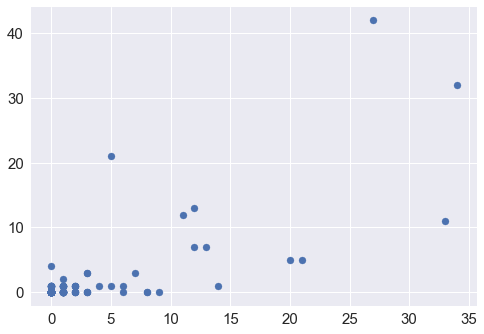

In [36]:
# make a copy of original dataframe
msa_df_copy = pd.DataFrame(msa_df.values, index=msa_df.index, columns=msa_df.columns)
msa_df_copy['n_articles'] = 0
msa_df_copy['terrorism_or_terrorist'] = 0
msa_df_copy['muslim_or_islam'] = 0
msa_df_copy['mental'] = 0

for i in df_out.index:
    row = df_out.loc[i]
    df_index = row['df_index']
    if row['prop_names_found'] > 0 or row['age_found'] or row['city_found']:
        msa_df_copy.loc[df_index, 'n_articles'] += 1
        
        text = row['article'].lower()
        if 'terrorism' in text or 'terrorist' in text:
            msa_df_copy.loc[df_index, 'terrorism_or_terrorist'] += 1
        if 'islam' in text or 'muslim' in text:
            msa_df_copy.loc[df_index, 'muslim_or_islam'] += 1
        if 'mental' in text:
            msa_df_copy.loc[df_index, 'mental'] += 1

temp = msa_df_copy[(msa_df_copy['terrorism_or_terrorist'] < 50)]

plt.scatter(temp['terrorism_or_terrorist'], temp['muslim_or_islam'])

In [55]:
print(df_parsed.loc[144])

CaseID                                                                                145
Title                                                                Santa Monica College
Location                                                         Santa Monica, California
City                                                                         Santa Monica
State                                                                          California
Latitude                                                                          34.0232
Longitude                                                                        -118.482
Number of Civilian Fatalities                                                           5
Number of Civilian Injured                                                              3
Number of Enforcement Fatalities                                                        0
Number of Enforcement Injured                                                           0
Total Numb

In [25]:
msa_df['simple_race'] = ''
for i in race_df.index:
    if i in msa_df.index:
        msa_df.loc[i, 'simple_race'] = race_df.loc[i, 'simple_race']
msa_df.tail()
print(set(msa_df.simple_race))
subset = msa_df[msa_df.simple_race == 'Middle Eastern']
print(subset[['Title', 'Possible Motive - General']])

{'Hispanic', 'Asian Hispanic', 'Unknown', 'Black', 'Middle Eastern', 'Other', 'White', 'Asian American', 'Native American', 'White Hispanic'}
                                          Title   Possible Motive - General
14                       Ianni's Club in Dallas              Social dispute
115                         Fort Hood Army Base  Political/Religious ideals
141  Ladera Ranch, Santa Ana, Tustin and Orange                     Unknown
144                        Santa Monica College              Mental illness
197                                     Phoenix            Domestic dispute
212       Amnicola Training Center, Chattanooga                     Unknown
333                  Orlando Nightclub Massacre            Multiple motives
